# App code for the flags model

This notebook explores Python code for more than just testing our flags Visual Recognition model.  This notebook prototypes code for sending images to the Visual Recognition model as well as processing the returned results.  Prototyping code here can make creating a web app later easier.

- Step 1: Install and import required libraries
- Step 2: Download sample files
- Step 3: Classify the images
- Step 4: Identify the top class
- Step 5: Play a few bars of the national anthem

## Step 1: Install and import required libraries

- [wget](https://pypi.org/project/wget/) for downloading sample video files to the notebook working directory
- watson_developer_cloud for working with [Watson Visual Recognition API](https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/python.html?python) and [Watson Text to Speech API](https://www.ibm.com/watson/developercloud/text-to-speech/api/v1/python.html?python)

In [ ]:
!pip install --upgrade wget

In [ ]:
!pip install --upgrade watson-developer-cloud

In [39]:
import wget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from watson_developer_cloud import VisualRecognitionV3
import json
import IPython

## Step 2: Download sample files

All material for the CASCON 2018 workshop "Building AI models using Watson Studio" is stored in GitHub: [CASCON-2018_Analyzing_images](https://github.com/spackows/CASCON-2018_Analyzing_images)

To work with the sample files, use wget to download the files from GitHub to the notebook working directory.

In [26]:
!rm -f *.jpg
!rm -f *.wav

filename_1 = 'flag1.jpg'
filename_2 = 'flag2.jpg'

anthem_1 = 'oh-canada.wav'
anthem_2 = 'star-spangled-banner.wav'
anthems = { 'Canada' : anthem_1, 'USA' : anthem_2 }

url_base = 'https://github.com/spackows/CASCON-2018_Analyzing_images/raw/master/flags/sample-app/static/'
url_1 = url_base + filename_1
url_2 = url_base + filename_2
url_3 = url_base + anthem_1
url_4 = url_base + anthem_2

wget.download( url_1 )
wget.download( url_2 )
wget.download( url_3 )
wget.download( url_4 )
!ls -l

total 7240
-rw-r--r-- 1 spark spark  210908 Oct 22 17:12 flag1.jpg
-rw-r--r-- 1 spark spark 5767153 Oct 22 17:12 flag2.jpg
drwxr-xr-x 2 spark spark    4096 Oct 22 15:48 logs
-rw-r--r-- 1 spark spark  729166 Oct 22 17:12 oh-canada.wav
drwxr-xr-x 2 spark spark    4096 Oct 22 15:57 spark-events
-rw-r--r-- 1 spark spark  646846 Oct 22 17:12 star-spangled-banner.wav
drwxr-xr-x 6 spark spark    4096 Oct 22 15:47 user-libs


In [48]:
def showImageFiles():
    fig, axs = plt.subplots( 1, 2, figsize=( 10, 5 ) )
    axs[0].imshow( mpimg.imread( 'flag1.jpg' ) )
    axs[0].set_title( filename_1 )
    axs[1].imshow( mpimg.imread( filename_2 ) )
    axs[1].set_title( filename_2 )
    for i in range(2):
        axs[i].set_xticks([])
        axs[i].set_yticks([])

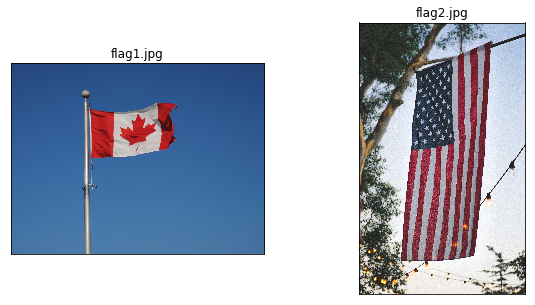

In [49]:
showImageFiles()

## Step 3: Classify the image

Use the [Watson Visual Recognition Python client API](https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/python.html?python) to send spectrogram images to our trained model for classification.

### Prerequisite
Look up the apikey for the Visual Recognition service instance and the ID of the custom model:
1. From the **Services** menu in Watson Studio (top of the screen) right-click "Watson Services" and then open the link in a new browser tab
2. In the new Watson services tab, click the service instance in the Visual Recognition list
3. In the **Overview** tab, scroll down to the list of your custom models and then click "Copy model ID"
4. In the **Credentials** tab, expand credentials and then copy the apikey

In [31]:
model_id = '' # <-- PASTE YOUR MODEL ID HERE
api_key  = '' # <-- PASTE YOUR APIKEY HERE

In [32]:
def classifyImage( flag_image_filename ):
    visual_recognition = VisualRecognitionV3( version='2018-03-19', iam_apikey=api_key )
    with open( flag_image_filename, 'rb' ) as image_file:
        results = visual_recognition.classify( image_file, threshold='0', classifier_ids=model_id ).get_result()
        return results

In [33]:
results = classifyImage( filename_1 )
print( json.dumps( results, indent=3 ) )

{
   "images": [
      {
         "classifiers": [
            {
               "name": "flags",
               "classifier_id": "flags_1317368117",
               "classes": [
                  {
                     "class": "Canada",
                     "score": 0.92
                  },
                  {
                     "class": "USA",
                     "score": 0.004
                  }
               ]
            }
         ],
         "image": "flag1.jpg"
      }
   ],
   "images_processed": 1,
   "custom_classes": 2
}


## Step 4: Identify the top class

In [36]:
def getKey( item ):
    return item["score"]

def getTopClass( results ):
    results_classes = results["images"][0]["classifiers"][0]["classes"]
    sorted_results_classes = sorted( results_classes, key=getKey, reverse=True )
    return sorted_results_classes[0]

def classifyFlag( flag_image_filename ):
    visual_recognition = VisualRecognitionV3( version='2018-03-19', iam_apikey=api_key )
    with open( flag_image_filename, 'rb' ) as image_file:
        results = visual_recognition.classify( image_file, threshold='0', classifier_ids=model_id ).get_result()
        top_class = getTopClass( results )
        return { 'top_class' : top_class, 'results' : results }

flag1.jpg
{'class': 'Canada', 'score': 0.92}


flag2.jpg
{'class': 'USA', 'score': 0.918}


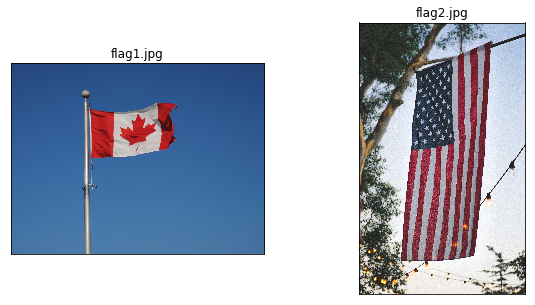

In [50]:
results_1 = classifyFlag( filename_1 )
results_2 = classifyFlag( filename_2 )
print( filename_1 )
print( results_1["top_class"] )
print( "\n" )
print( filename_2 )
print( results_2["top_class"] )
showImageFiles()

## Step 5: Play a few bars of the national anthem

Play the correct audio for the image.

In [51]:
print( json.dumps( anthems, indent=3 ) )

{
   "Canada": "oh-canada.wav",
   "USA": "star-spangled-banner.wav"
}


In [63]:
def getAnthemForFlag( flag_image_filename ):
    results = classifyFlag( flag_image_filename )
    top_class_name = results["top_class"]["class"]
    anthem_filename = anthems[top_class_name]
    showImageFiles()
    print( flag_image_filename )
    return anthem_filename    

flag1.jpg


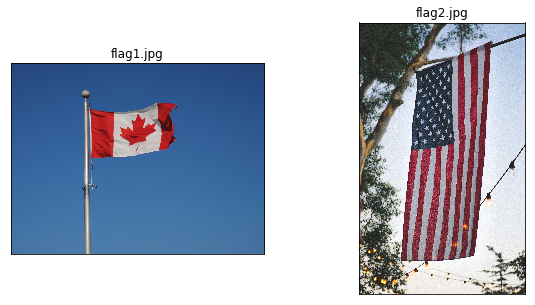

In [64]:
anthem_filename = getAnthemForFlag( filename_1 )
IPython.display.Audio( anthem_filename )

flag2.jpg


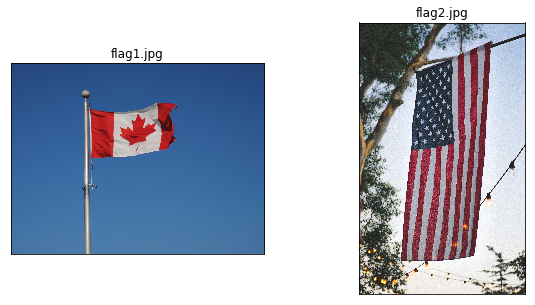

In [65]:
anthem_filename = getAnthemForFlag( filename_2 )
IPython.display.Audio( anthem_filename )

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.